In [73]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

import sys
import pickle

import re
from pprint import pprint
from scipy import interp
from scipy import sparse
from itertools import cycle

import time

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem.lancaster import *
from nltk.stem.wordnet import *

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc

In [2]:
random_state = 7

# Load Data

In [3]:
reuters_path = '~/dev/rtc/data/text/reuters21578'

In [4]:
# https://raw.githubusercontent.com/ZhibingChen/DM-Reuters21578/master/reutersCSV.csv
csv_df = pd.read_csv(reuters_path + '/reutersCSV.csv', encoding='iso-8859-1', keep_default_na=False)

In [5]:
csv_df.head()

,pid,fileName,purpose,topic.acq,topic.alum,topic.austdlr,topic.austral,topic.barley,topic.bfr,topic.bop,...,topic.tung,topic.tung.oil,topic.veg.oil,topic.wheat,topic.wool,topic.wpi,topic.yen,topic.zinc,doc.title,doc.text
0,1,0,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,BAHIA COCOA REVIEW,Showers continued throughout the week in the B...
1,2,0,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,STANDARD OIL &lt;SRD> TO FORM FINANCIAL UNIT,Standard Oil Co and BP North America Inc said ...
2,3,0,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,TEXAS COMMERCE BANCSHARES &lt;TCB> FILES PLAN,Texas Commerce Bancshares Inc's Texas Commerce...
3,4,0,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,TALKING POINT/BANKAMERICA &lt;BAC> EQUITY OFFER,BankAmerica Corp is not under pressure to act ...
4,5,0,train,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department reported the f...


#### Peek at texts

In [6]:
# 1 -- 5
(title, text) = csv_df.iloc[1][['doc.title', 'doc.text']]
print(title, '\n\n', text)

STANDARD OIL &lt;SRD> TO FORM FINANCIAL UNIT 

 Standard Oil Co and BP North America Inc said they plan to form a venture to manage the money market borrowing and investment activities of both companies.     BP North America is a subsidiary of British Petroleum Co Plc &lt;BP>, which also owns a 55 pct interest in Standard Oil.     The venture will be called BP/Standard Financial Trading and will be operated by Standard Oil under the oversight of a joint management committee.   Reuter 


#### Topics

In [7]:
all_topics = [ re.sub('topic\.', '', col) for col in csv_df.columns if col.startswith('topic.') ]
print('\n', 'num topics:', len(all_topics))
pd.DataFrame(all_topics, columns=['topic name']).head(15)


 num topics: 135


,topic name
0,acq
1,alum
2,austdlr
3,austral
4,barley
5,bfr
6,bop
7,can
8,carcass
9,castor.meal


### Prepare topics -- the labels we are going to predict

Add them to a dataframe in two ways

#### 1) As lists of zeros and ones -- for humans to read,

In [8]:
topics_binarized = np.array(csv_df.values[:,3:-3])

#### 2) As lists of strings -- for multi-label classifiers.

In [9]:
def topic_list_from_binarized(binarized):
    return [ topic for (has, topic) in zip(binarized, all_topics) if has == 1 ]

topic_lists = [ topic_list_from_binarized(binarized) for binarized in topics_binarized ]

#### Combine all

In [10]:
df = csv_df[[ 'pid', 'purpose', 'doc.title', 'doc.text' ]]
df = df.assign(topic_list = topic_lists)
df = df.assign(topics_binarized = topics_binarized.tolist())
df = df.assign(num_topics = np.array([ len(lst) for lst in topic_lists ]))
df.head()

,pid,purpose,doc.title,doc.text,topic_list,topics_binarized,num_topics
0,1,train,BAHIA COCOA REVIEW,Showers continued throughout the week in the B...,[cocoa],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1
1,2,train,STANDARD OIL &lt;SRD> TO FORM FINANCIAL UNIT,Standard Oil Co and BP North America Inc said ...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
2,3,train,TEXAS COMMERCE BANCSHARES &lt;TCB> FILES PLAN,Texas Commerce Bancshares Inc's Texas Commerce...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
3,4,train,TALKING POINT/BANKAMERICA &lt;BAC> EQUITY OFFER,BankAmerica Corp is not under pressure to act ...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
4,5,train,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department reported the f...,"[barley, corn, grain, oat, sorghum, wheat]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6


### So the whole data is...

In [11]:
df_train = df[df['purpose'] == 'train']
df_test = df[df['purpose'] == 'test']

In [12]:
n_classes = len(all_topics)

In [13]:
print('total docs', len(df))
print('num train examples', len(df_train))
print('num test examples', len(df_test))
df.head()

total docs 21578
num train examples 14668
num test examples 6188


,pid,purpose,doc.title,doc.text,topic_list,topics_binarized,num_topics
0,1,train,BAHIA COCOA REVIEW,Showers continued throughout the week in the B...,[cocoa],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1
1,2,train,STANDARD OIL &lt;SRD> TO FORM FINANCIAL UNIT,Standard Oil Co and BP North America Inc said ...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
2,3,train,TEXAS COMMERCE BANCSHARES &lt;TCB> FILES PLAN,Texas Commerce Bancshares Inc's Texas Commerce...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
3,4,train,TALKING POINT/BANKAMERICA &lt;BAC> EQUITY OFFER,BankAmerica Corp is not under pressure to act ...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
4,5,train,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department reported the f...,"[barley, corn, grain, oat, sorghum, wheat]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6


### Some stats

#### Num topics per document

total docs: 21578
docs with at least one topic: 11324
docs with more than one topic: 1859
docs with more than two topics: 523
docs with exactly one topic: 9465


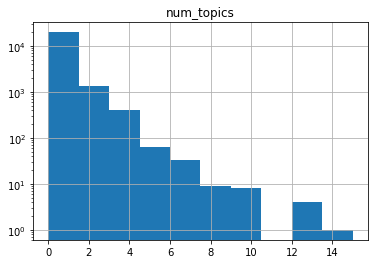

In [14]:
fig, ax = plt.subplots()
ax.set_yscale('log')

df[['num_topics']].hist(ax = ax)

print('total docs:', len(df))
print('docs with at least one topic:', len(df[df['num_topics'] > 0]))
print('docs with more than one topic:', len(df[df['num_topics'] > 1]))
print('docs with more than two topics:', len(df[df['num_topics'] > 2]))
print('docs with exactly one topic:', len(df[df['num_topics'] == 1]))

#### Num documents per topic

##### Calculate

In [15]:
really_want_to_recalc_num_docs_by_topic = False
if really_want_to_recalc_num_docs_by_topic:
    num_docs_by_topic = df.from_records(
        data = [ 
            (topic, len(df[df.apply(lambda row: topic in row['topic_list'], axis=1)]))
            for topic in all_topics
        ],
        columns = [ 'topic', 'num_docs' ]
    ).sort_values('num_docs', ascending = False)
    # beware not to overwrite data that is costly to compute again
    # num_docs_by_topic.to_csv(reuters_path + '/num_docs_by_topic.csv', index = False)
else:
    num_docs_by_topic = pd.read_csv(reuters_path + '/num_docs_by_topic.csv')
    num_docs_by_topic = num_docs_by_topic.sort_values('num_docs', ascending = False)

##### Show

[Text(0,0.5,'num_docs')]

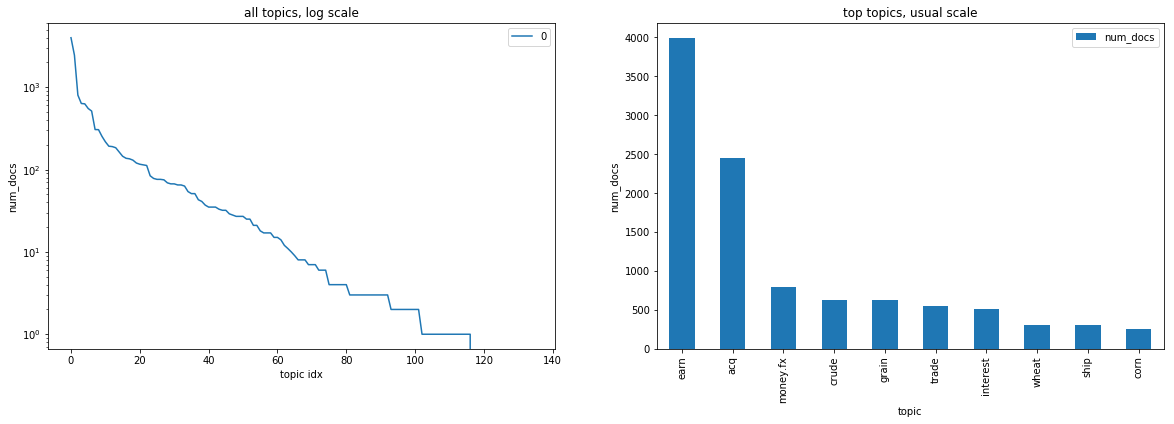

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].set_yscale('log')
axs[0].set_title('all topics, log scale')
axs[1].set_title('top topics, usual scale')
pd.DataFrame(num_docs_by_topic[['num_docs']].values).plot(ax = axs[0]).set(xlabel = 'topic idx', ylabel = 'num_docs')
num_docs_by_topic.head(10).plot(ax = axs[1], kind = 'bar', x = 'topic').set(ylabel = 'num_docs')

#### Num words per document

In [17]:
num_words = df[['doc.title', 'doc.text']].apply(
    lambda row: len((row['doc.title'] + ' ' + row['doc.text']).split()),
    axis = 1
)

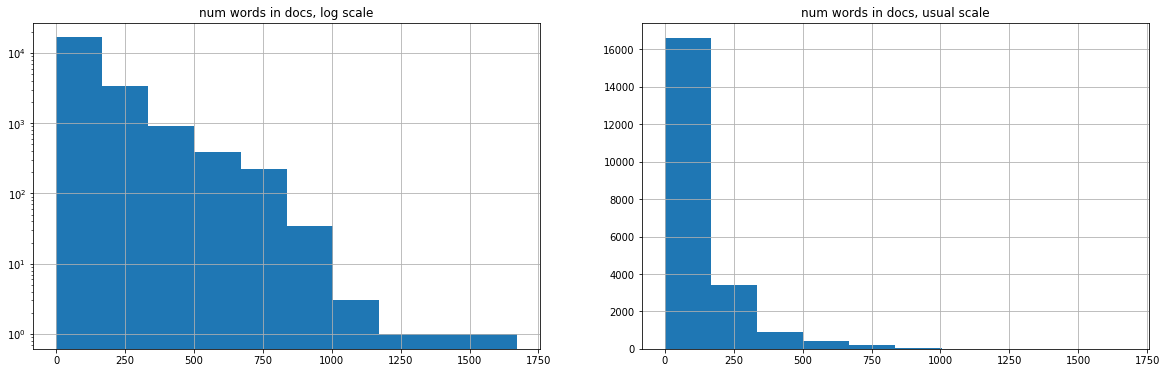

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].set_yscale('log')
axs[0].set_title('num words in docs, log scale')
axs[1].set_title('num words in docs, usual scale')

num_words.hist(ax = axs[0])
num_words.hist(ax = axs[1])

#### Total num distinct words and word counts

In [19]:
def get_counts_by_word(docs):
    word_counts = {}
    for doc in docs:
        for word in doc.split():
            if len(word) > 0:
                if word not in word_counts:
                    word_counts[word] = 0
                word_counts[word] += 1
    return word_counts

In [20]:
counts_by_word = get_counts_by_word(
    df.apply(lambda row : row['doc.title'] + ' ' + row['doc.text'], axis = 1).values
)

In [21]:
len(counts_by_word.keys())

134890

## Keep only a few good topics and only single-topic docs

In [22]:
roughly_even_topics = [
    'money.fx',
    'crude',
    'grain',
    'trade',
    'interest',
]
all_topics = roughly_even_topics

#### Later we will need a special binary representation of labels
For compatibility with library functions that calculate metrics

In [23]:
roughly_even_topics_set = set(roughly_even_topics)
df = df[df.apply(
    lambda row: len(row['topic_list']) == 1 and set(row['topic_list']).issubset(roughly_even_topics_set),
    axis = 1
)]

In [24]:
binarizer = MultiLabelBinarizer(classes = roughly_even_topics)

In [25]:
topic_lists = df.apply(lambda row : row['topic_list'][0], axis = 1).values.reshape(len(df), 1)
roughly_even_topics_binarized = binarizer.fit_transform(topic_lists)
roughly_even_topics_binarized[:5]

array([[0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0]])

In [26]:
df = df.assign(topics_binarized = roughly_even_topics_binarized.tolist())

### So the data we will use is...

In [27]:
df_train = df[df['purpose'] == 'train']
df_test = df[df['purpose'] == 'test']

In [28]:
n_classes = len(all_topics)

In [29]:
print('total docs', len(df))
print('num train examples', len(df_train))
print('num test examples', len(df_test))
df.head()

total docs 1414
num train examples 943
num test examples 377


,pid,purpose,doc.title,doc.text,topic_list,topics_binarized,num_topics
46,47,train,BRAZIL ANTI-INFLATION PLAN LIMPS TO ANNIVERSARY,"inflation plan, initially hailed at home and a...",[trade],"[0, 0, 0, 1, 0]",1
123,124,train,U.S. GRAIN CARLOADINGS FALL IN WEEK,"U.S. grain carloadings totaled 26,108 cars in ...",[grain],"[0, 0, 1, 0, 0]",1
126,127,train,DIAMOND SHAMROCK (DIA) CUTS CRUDE PRICES,Diamond Shamrock Corp said that effective toda...,[crude],"[0, 1, 0, 0, 0]",1
135,136,train,GAO LIKELY TO SHOW CERTS MORE COSTLY THAN CASH,A study on grain certificates due out shortly ...,[grain],"[0, 0, 1, 0, 0]",1
143,144,train,OPEC MAY HAVE TO MEET TO FIRM PRICES - ANALYSTS,OPEC may be forced to meet before a scheduled ...,[crude],"[0, 1, 0, 0, 0]",1


### Same stats as above -- this time, on the sub-sampled data

#### Num documents per topic

In [30]:
num_docs_by_topic = df.from_records(
    data = [ 
        (topic, len(df[df.apply(lambda row: topic in row['topic_list'], axis=1)]))
        for topic in all_topics
    ],
    columns = [ 'topic', 'num_docs' ]
).sort_values('num_docs', ascending = False)
# beware not to overwrite data that is costly to compute again
# num_docs_by_topic.to_csv(reuters_path + '/num_docs_by_topic.csv', index = False)

[Text(0,0.5,'num_docs')]

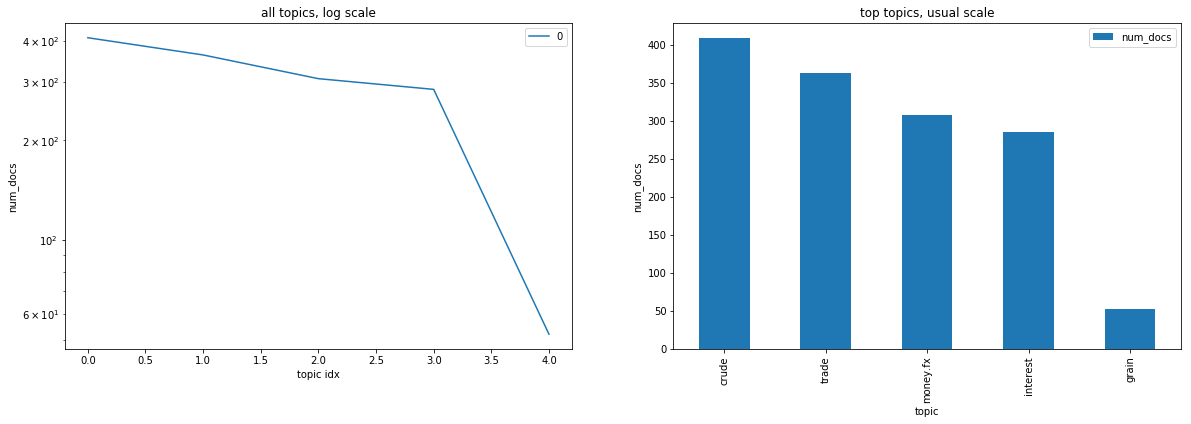

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].set_yscale('log')
axs[0].set_title('all topics, log scale')
axs[1].set_title('top topics, usual scale')
pd.DataFrame(num_docs_by_topic[['num_docs']].values).plot(ax = axs[0]).set(xlabel = 'topic idx', ylabel = 'num_docs')
num_docs_by_topic.head(10).plot(ax = axs[1], kind = 'bar', x = 'topic').set(ylabel = 'num_docs')

#### Num words per document

In [32]:
num_words = df[['doc.title', 'doc.text']].apply(
    lambda row: len((row['doc.title'] + ' ' + row['doc.text']).split()),
    axis = 1
)

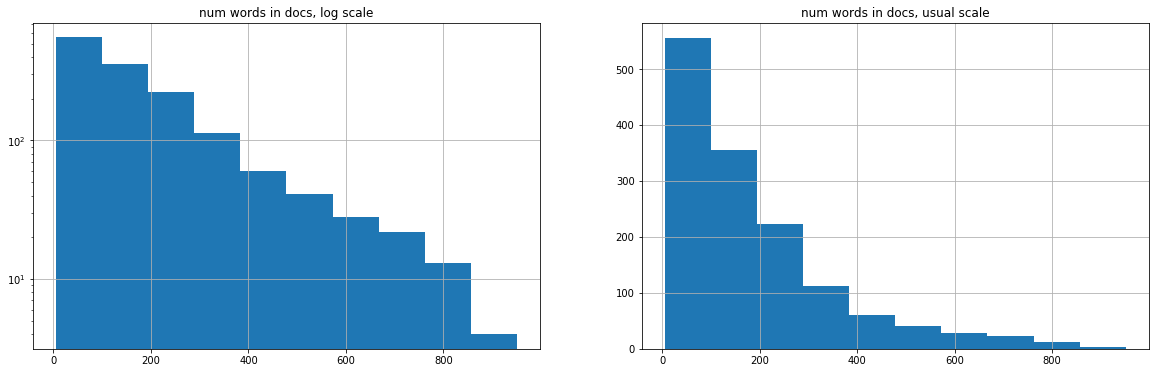

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].set_yscale('log')
axs[0].set_title('num words in docs, log scale')
axs[1].set_title('num words in docs, usual scale')

num_words.hist(ax = axs[0])
num_words.hist(ax = axs[1])

#### Total num distinct words and word counts

In [34]:
def get_counts_by_word(docs):
    word_counts = {}
    for doc in docs:
        for word in doc.split():
            if len(word) > 0:
                if word not in word_counts:
                    word_counts[word] = 0
                word_counts[word] += 1
    return word_counts

In [35]:
counts_by_word = get_counts_by_word(
    df.apply(lambda row : row['doc.title'] + ' ' + row['doc.text'], axis = 1).values
)

In [36]:
len(counts_by_word.keys())

23568

# Create features

The whole task actually revolves around how we represent the documents as vectors that can be fed to a classifier.

Here we will use the Bag Of Words approach:

1. split each text to tokens and create a set of all words of all texts -- the vocabulary,
2. create a matrix in which rows correspond to docs and columns -- to words,
3. fill the matrix with either of:
  * 1 if the word is found in the doc and else 0,
  * word count in doc,
  * TF-IDF numbers.
  
Questions:

1. How to split the text to tokens ? By whitespace ? Punctuation ? Some other way ?
2. What if the words have different forms ?
3. What if there are lots of different numbers ?
4. What if there are common sequences of words, like "United Kingdom", "Russian Federation", "United States of America"
5. What if there are lots of words like "a", "the", "they" etc. that appear in many documets ?

### What do texts actually look like

In [37]:
# 1   -- just regular text
# 4   -- longer text
# 5   -- only title
# 6   -- has &lt; (see above) and some numbers
# 100 -- has a table of some sort
#
# some words are upper case, some lower, some even mixed (doc 5)
# a lot of punctuation
# numbers are in different formats
# Reuter word at the end of each document
# some words are abbreviated

(title, text) = df.iloc[1][['doc.title', 'doc.text']]
print(title, '\n\n', text)

U.S. GRAIN CARLOADINGS FALL IN WEEK 

 U.S. grain carloadings totaled 26,108 cars in the week ended February 21, down 2.2 pct from the previous week but 22.8 pct above the corresponding week a year ago, the Association of American Railroads reported.     Grain mill product loadings in the week totalled 11,382 cars, down 1.8 pct from the previous week but 7.6 pct above the same week a year earlier, the association said.  Reuter 


### Pre-process text

In [38]:
def lower_case(string):
    return string.lower()

def fix_lt(string):
    # fix the HTML-escaped less-than sign
    return re.sub(r'&lt;', '<', string)

def remove_reuter(string):
    # fix the HTML-escaped less-than sign
    return re.sub(r'reuter$', '', string)

def replace_non_alphanumeric_with_space(string):
    # replace punctuation and different whitespace with space character
    return re.sub(r'[^a-z0-9 ]', ' ', string)

def strip_punctuation(string):
    # remove punctuation
    return re.sub(r'[^a-z0-9\s]', ' ', string)

def remove_stop_words(string, stop_words):
    return ' '.join([ word for word in re.split(' ', string) if not word in stop_words ])

def replace_numeric_with_literal(string):
    return re.sub(r'([0-9]+ ?)+', '<num> ', string)

def compact_whitespace(string):
    return re.sub(r'\s+', ' ', string)

def stem(string, stemmer):
    return ' '.join([ 
        stemmer.stem(word) if hasattr(stemmer, 'stem') else stemmer.lemmatize(word)
        for word in re.split(' ', string) if not word in stop_words 
    ])

In [39]:
stop_words = stopwords.words('english')

stemmer = LancasterStemmer()
# stemmer = PorterStemmer()

In [40]:
# nltk.download('wordnet')
# stemmer = WordNetLemmatizer()

In [41]:
def pre_process(string):
    s = lower_case(string)
    s = fix_lt(s)
    s = remove_reuter(s)
    s = strip_punctuation(s)
    s = remove_stop_words(s, stop_words)
    s = compact_whitespace(s)
    s = replace_numeric_with_literal(s)
    s = stem(s, stemmer)
    return s.strip()

In [42]:
example = 'Autobahn-FX 2, &lt;RMS> are now being actively developed; GDS decom will be finished by 2055 or 2056'
pre_process(example)

'autobahn fx <num> rms act develop gds decom fin <num>'

In [43]:
(title, text) = df.iloc[1][['doc.title', 'doc.text']]
print(title, '\n\n', text, '\n\n', pre_process(title + ' ' + text))

U.S. GRAIN CARLOADINGS FALL IN WEEK 

 U.S. grain carloadings totaled 26,108 cars in the week ended February 21, down 2.2 pct from the previous week but 22.8 pct above the corresponding week a year ago, the Association of American Railroads reported.     Grain mill product loadings in the week totalled 11,382 cars, down 1.8 pct from the previous week but 7.6 pct above the same week a year earlier, the association said.  Reuter  

 u grain carload fal week u grain carload tot <num> car week end febru <num> pct prevy week <num> pct correspond week year ago assocy am railroad report grain mil produc load week total <num> car <num> pct prevy week <num> pct week year ear assocy said reut


#### Get pre-processed text sets

In [44]:
def pre_process_df(df):
    return df.apply(lambda row : pre_process(row['doc.title'] + ' ' + row['doc.text']), axis = 1).values

In [45]:
pre_processed_train = pre_process_df(df_train)

In [46]:
pre_processed_test = pre_process_df(df_test)

#### Check vocabulary

In [47]:
counts_by_word_pre_processed_train = get_counts_by_word(pre_processed_train)

In [48]:
len(counts_by_word_pre_processed_train)

5199

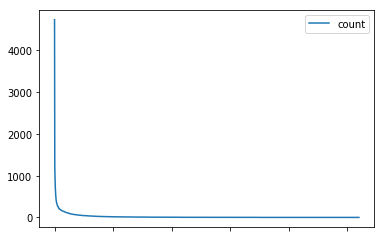

In [49]:
pd.DataFrame(pd.Series(counts_by_word_pre_processed_train, name='count')).sort_values('count', ascending=False).plot()

In [50]:
num_words = 3000

In [51]:
pd.DataFrame(pd.Series(counts_by_word_pre_processed_train, name='count')).sort_values('count', ascending=False)[4:num_words].head(20)

,count
bank,1250
oil,1108
bil,1062
pct,1029
rat,964
reut,897
mln,857
market,833
would,814
year,756


In [52]:
pd.DataFrame(pd.Series(counts_by_word_pre_processed_train, name='count')).sort_values('count', ascending=False)[:num_words].tail()

,count
w<num>,2
autonom,2
altogeth,2
sak,2
caf,2


In [53]:
top_words = list(counts_by_word_pre_processed_train.items())
top_words.sort(key = lambda it: it[1])
top_words.reverse()
top_words = [ word for word, count in top_words[:num_words] ]
print(len(top_words))
top_words[:10]

3000


['<num>', 'said', 'trad', 'u', 'bank', 'oil', 'bil', 'pct', 'rat', 'reut']

In [54]:
def replace_rare_words_with_literal(string, top_words):
    return ' '.join([ (word if word in top_words else '<unk>') for word in re.split(' ', string) ])

In [55]:
pre_processed_train = [ 
    replace_rare_words_with_literal(doc, top_words) for doc in pre_processed_train
]

pre_processed_test = [ 
    replace_rare_words_with_literal(doc, top_words) for doc in pre_processed_test
]

In [56]:
print(pre_processed_train[:3])
print()
print(pre_processed_test[:3])

['brazil ant infl plan <unk> annivers infl plan init <unk> hom abroad <unk> econom <unk> toward first annivers amid soar pric widespread short foreign pay cris annount last febru <num> plan froz pric fix valu new <unk> cur end widespread index econom bid halt country <num> pct infl rat within year plan collaps situ wors although infl least econom work lead bank econom said <unk> plan accompany dram revers foreign trad account <num> brazil an trad surplus sufficy cov <num> bil dlrs nee serv <num> bil dlr foreign debt first nin month <num> seem target rep month surplus av on bil dlrs export divert import increas avoid domest short trad surpl plung <num> mln dlrs octob sint av <num> mln reut', 'u grain carload fal week u grain carload tot <num> car week end febru <num> pct prevy week <num> pct correspond week year ago assocy am railroad report grain mil produc load week total <num> car <num> pct prevy week <num> pct week year ear assocy said reut', 'diamond shamrock dia cut crud pric diam

### Vectorize text

In [57]:
vectorizer = TfidfVectorizer(ngram_range = (1, 1))

vectorizer.fit(pre_processed_train)

X_train = vectorizer.transform(pre_processed_train, copy=True)
X_test = vectorizer.transform(pre_processed_test, copy=True)

In [58]:
X_train.shape

(943, 2986)

### Prepare labels

In [59]:
def single_label(df):
    return df.apply(lambda row : row['topic_list'][0], axis = 1).values

In [60]:
def binarized(df):
    return sparse.csr_matrix(df.apply(lambda row : row['topics_binarized'], axis = 1).values.tolist())

In [61]:
y_train = single_label(df_train)
y_test = single_label(df_test)

# Train the model

In [62]:
# y_train_labels = binarizer.inverse_transform(y_train)

In [63]:
# clf = MLPClassifier()
# clf = MultinomialNB()
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs') # accepts array of single labels

clf = clf.fit(X_train, y_train)

# Check quality

In [64]:
y_test_predicted_labels = clf.predict(X_test)
# y_test_predicted_scores = clf.decision_function(X_test)

In [65]:
y_test_predicted_labels_binary = binarizer.transform(y_test_predicted_labels.reshape(len(y_test_predicted_labels), 1))
y_test_binary = binarizer.transform(y_test.reshape(len(y_test), 1))

In [66]:
def print_evaluation_scores(y_test, predicted):
    print('accuracy', accuracy_score(y_test, predicted))
    for avg in [ 'micro', 'macro', 'weighted' ]:
        print('f1', avg, f1_score(y_test, predicted, average = avg))
        print('precision', avg, average_precision_score(y_test, predicted, average = avg))

In [67]:
print_evaluation_scores(y_test_binary, y_test_predicted_labels_binary)

accuracy 0.9363395225464191
f1 micro 0.9363395225464191
precision micro 0.8894637969731722
f1 macro 0.9249925350513717
precision macro 0.8728618721996421
f1 weighted 0.9354465797174518
precision weighted 0.8918616599896273


## Fiddle around with the classifier

In [68]:
df_test[4:9]

,pid,purpose,doc.title,doc.text,topic_list,topics_binarized,num_topics
14911,14912,test,JAPAN GIVEN LITTLE HOPE OF AVOIDING U.S. SANCT...,A top U.S. Official said Japan has little chan...,[trade],"[0, 0, 0, 1, 0]",1
14986,14987,test,STOLTENBERG SEES MOVES TO STRENGTHEN PARIS ACCORD,West German Finance Minister Gerhard Stoltenbe...,[money.fx],"[1, 0, 0, 0, 0]",1
15047,15048,test,TOP OFFICIALS ARRIVE AT TREASURY FOR G-5 TALKS,Top officials of leading industrial nations ar...,[money.fx],"[1, 0, 0, 0, 0]",1
15048,15049,test,FED EXPECTED TO SET CUSTOMER REPURCHASES,The Federal Reserve is expected to intervene i...,[interest],"[0, 0, 0, 0, 1]",1
15091,15092,test,"FED SETS OVERNIGHT SYSTEM REPURCHASES, FED SAYS",,[interest],"[0, 0, 0, 0, 1]",1


In [69]:
print(df_test.iloc[5]['doc.title'] + '\n\n' + df_test.iloc[5]['doc.text'])

STOLTENBERG SEES MOVES TO STRENGTHEN PARIS ACCORD

West German Finance Minister Gerhard Stoltenberg said today's meetings of major industrial countries would look at ways of strengthening the Paris accord on stabilizing foreign exchange rates.     Stoltenberg told journalists he saw no fundamental weakness of the February 22 agreement of the Group of Five countries and Canada to keep exchange rates near the then-current levels.     But he declined to say what measures would be discussed ahead of a communique of the Group of Seven ministers later today.     Stoltenberg and Bundesbank President Karl Otto Poehl said the importance of the Paris agreement, also known as the Louvre accord, had been underestimated.     Stoltenberg said there is greater agreement now among major countries than six months ago, at the time of the annual meeting of the International Monetary Fund and World Bank, marked by sharp discord between the United States and its major trading partners.     "There is no fun

## Interpreting features

In [70]:
num_top_features = 10
pd.set_option('max_colwidth', 200)
pd.DataFrame.from_records(
    columns = [ 'topic', 'top_words' ],
    data = [ (
        cls, 
        [ vectorizer.get_feature_names()[i] for i in np.argpartition(coefs, -num_top_features)[-num_top_features:] ]
    ) for cls, coefs in zip(clf.classes_, clf.coef_) ]
)

,topic,top_words
0,crude,"[expl, bpd, refinery, energy, petrole, pric, crud, barrel, opec, oil]"
1,grain,"[elev, cer, ton, usd, soviet, agricult, farm, crop, cert, grain]"
2,interest,"[discount, point, cut, num, fed, bank, rat, pct, interest, prim]"
3,money.fx,"[system, exchang, stg, doll, cur, monet, stabl, bank, money, market]"
4,trade,"[janu, export, gat, bil, deficit, surpl, import, japanes, jap, trad]"


# Full Flow

In [71]:
# PARAMETERS -------------------------------------------------------
CASE_NAME = 'CASE_NAME'
TOPICS = 'TOPICS'
MODEL = 'MODEL'
MODEL_NAME = 'MODEL_NAME'
VECTORIZER = 'VECTORIZER'
VECTORIZER_NAME = 'VECTORIZER_NAME'
PP_LOWER_CASE = 'PP_LOWER_CASE'
PP_FIX_LT = 'PP_FIX_LT'
PP_REMOVE_REUTER = 'PP_REMOVE_REUTER'
PP_STRIP_PUNCTUATION = 'PP_STRIP_PUNCTUATION'
PP_REMOVE_STOP_WORDS = 'PP_REMOVE_STOP_WORDS'
PP_COMPACT_WHITESPACE = 'PP_COMPACT_WHITESPACE'
PP_NUMERIC = 'PP_NUMERIC'
PP_REPLACE_NUMERIC_WITH_LITERAL = 'PP_REPLACE_NUMERIC_WITH_LITERAL'
PP_NUMERIC_AS_IS = 'PP_NUMERIC_AS_IS'
PP_NUMERIC_DROP = 'PP_NUMERIC_DROP'
PP_STEM = 'PP_STEM'
PP_STEM_PORTER = 'PP_STEM_PORTER'
PP_STEM_LANCASTER = 'PP_STEM_LANCASTER'
PP_LEMMATIZE = 'PP_LEMMATIZE'
PP_STEM_NONE = 'PP_STEM_NONE'
NUM_TOP_WORDS_TO_TAKE = 'NUM_TOP_WORDS_TO_TAKE'
RARE_WORDS = 'RARE_WORDS'
RARE_WORDS_REPLACE = 'RARE_WORDS_REPLACE'
RARE_WORDS_DROP = 'RARE_WORDS_DROP'
RARE_WORDS_AS_IS = 'RARE_WORDS_AS_IS'

def default_parameters():
    return {
        MODEL_NAME : "LogisticRegression(multi_class='multinomial', solver='lbfgs')",
        VECTORIZER_NAME : "TfidfVectorizer(ngram_range = (1, 1))",
        CASE_NAME : 'default -- logreg with tfidf',
        MODEL : LogisticRegression(multi_class='multinomial', solver='lbfgs'), # accepts array of single labels
        VECTORIZER : TfidfVectorizer(ngram_range = (1, 1)),
        TOPICS : [ 'money.fx', 'crude', 'grain', 'trade', 'interest', ], # classes for single-label multi-class model
        PP_LOWER_CASE : True,
        PP_FIX_LT : True,
        PP_REMOVE_REUTER : True,
        PP_STRIP_PUNCTUATION : True,
        PP_REMOVE_STOP_WORDS : True,
        PP_COMPACT_WHITESPACE : True,
        PP_NUMERIC: PP_REPLACE_NUMERIC_WITH_LITERAL, # PP_NUMERIC_DROP # PP_NUMERIC_AS_IS
        PP_STEM : PP_STEM_LANCASTER, # PP_STEM_PORTER # PP_STEM_LANCASTER # PP_LEMMATIZE # PP_STEM_NONE
        RARE_WORDS : RARE_WORDS_REPLACE, # RARE_WORDS_DROP
        NUM_TOP_WORDS_TO_TAKE : 3000, # top words by count to build vocabulary of
    }

# LABEL BINARIZATION -----------------------------------------------

def topic_list_from_binarized(binarized, topics):
    return [ topic for (has, topic) in zip(binarized, topics) if has == 1 ]

def single_label(df):
    return df.apply(lambda row : row['topic_list'][0], axis = 1).values

def binarized(df):
    return sparse.csr_matrix(df.apply(lambda row : row['topics_binarized'], axis = 1).values.tolist())

# PREPROCESSING ----------------------------------------------------

def lower_case(string):
    return string.lower()

def fix_lt(string):
    # fix the HTML-escaped less-than sign
    return re.sub(r'&lt;', '<', string)

def remove_reuter(string):
    # fix the HTML-escaped less-than sign
    return re.sub(r'reuter$', '', string)

def replace_non_alphanumeric_with_space(string):
    # replace punctuation and different whitespace with space character
    return re.sub(r'[^a-z0-9 ]', ' ', string)

def strip_punctuation(string):
    # remove punctuation
    return re.sub(r'[^a-z0-9\s]', ' ', string)

def remove_stop_words(string, stop_words):
    return ' '.join([ word for word in re.split(' ', string) if not word in stop_words ])

def replace_numeric_with_literal(string, literal = '<num> '):
    return re.sub(r'([0-9]+ ?)+', literal, string)

def compact_whitespace(string):
    return re.sub(r'\s+', ' ', string)

def stem(string, stemmer):
    return ' '.join([ stemmer.stem(word) for word in re.split(' ', string) if not word in stop_words ])

def lemmatize(string, lemmatizer):
    return ' '.join([ lemmatizer.lemmatize(word) for word in re.split(' ', string) if not word in stop_words ])

stop_words = stopwords.words('english')

def pre_process(params, string):
    s = string
    if params[PP_LOWER_CASE]:
        s = lower_case(string)
    if params[PP_FIX_LT]:
        s = fix_lt(s)
    if params[PP_REMOVE_REUTER]:
        s = remove_reuter(s)
    if params[PP_STRIP_PUNCTUATION]:
        s = strip_punctuation(s)
    if params[PP_REMOVE_STOP_WORDS]:
        s = remove_stop_words(s, stop_words)
    if params[PP_COMPACT_WHITESPACE]:
        s = compact_whitespace(s)
    if params[PP_NUMERIC] == PP_REPLACE_NUMERIC_WITH_LITERAL:
        s = replace_numeric_with_literal(s)
    elif params[PP_NUMERIC] == PP_NUMERIC_DROP:
        s = replace_numeric_with_literal(s, '')
    if params[PP_STEM] == PP_STEM_LANCASTER:
        stemmer = LancasterStemmer()
        s = stem(s, stemmer)
    elif params[PP_STEM] == PP_STEM_PORTER:
        stemmer = PorterStemmer()
        s = stem(s, stemmer)
    elif params[PP_STEM] == PP_LEMMATIZE:
        lemmatizer = WordNetLemmatizer()
        s = lemmatize(s, lemmatizer)
    return s.strip()

def pre_process_df(params, df):
    return df.apply(lambda row : pre_process(params, row['doc.title'] + ' ' + row['doc.text']), axis = 1).values

def get_counts_by_word(docs):
    word_counts = {}
    for doc in docs:
        for word in doc.split():
            if len(word) > 0:
                if word not in word_counts:
                    word_counts[word] = 0
                word_counts[word] += 1
    return word_counts

def replace_rare_words_with_literal(string, top_words, literal = '<unk>'):
    return ' '.join([ (word if word in top_words else literal) for word in re.split(' ', string) ])

# METRICS --------------------------------------------------------

def get_and_print_evaluation_scores(y_test, predicted):
    accuracy = accuracy_score(y_test, predicted)
    precision_and_f1 = dict()
    print('accuracy', accuracy)
    for avg in [ 'micro', 'macro', 'weighted' ]:
        precision = average_precision_score(y_test, predicted, average = avg)
        f1 = f1_score(y_test, predicted, average = avg)
        precision_and_f1[avg] = (precision, f1)
        print('f1', avg, f1)
        print('precision', avg, precision)
        # 'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives.
        # 'macro': Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
        # 'weighted': Calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.
    return (accuracy, precision_and_f1)

# ACTUAL FLOW ----------------------------------------------------

def run(params):
    print('------------------------------------------------------')
    print(time.ctime(time.time()))
    print(params[CASE_NAME])

    topics = params[TOPICS]
    n_classes = len(topics)
    topics_set = set(topics)

    # LOAD DATA --------------------------------------------------------
    started_loading = time.time()
    
    reuters_path = '~/dev/rtc/data/text/reuters21578'
    # https://raw.githubusercontent.com/ZhibingChen/DM-Reuters21578/master/reutersCSV.csv
    csv_df = pd.read_csv(reuters_path + '/reutersCSV.csv', encoding='iso-8859-1', keep_default_na=False)

    # ORGANIZE DATA ----------------------------------------------------

    # take only what's needed (columns 'topic_list' and 'num_topics' added separately below)
    df = csv_df[[ 'pid', 'purpose', 'doc.title', 'doc.text' ]]

    # get specified topics
    all_topics = [ re.sub('topic\.', '', col) for col in csv_df.columns if col.startswith('topic.') ]

    # store topics for all docs before filtering them according to the specified topics list
    all_topics_binary = np.array(csv_df.values[:,3:-3])
    topic_lists_long = [ topic_list_from_binarized(binary, all_topics) for binary in all_topics_binary ]
    df = df.assign(topic_list = topic_lists_long)
    df = df.assign(num_topics = np.array([ len(lst) for lst in topic_lists_long ]))

    # keep only docs that have exactly one topic and that is within the specified topics list
    df = df[df.apply(
        lambda row: row['num_topics'] == 1 and set(row['topic_list']).issubset(topics_set),
        axis = 1
    )]

    # Binarizing labels for API compatibility
    # could have taken from CSV with some dataframe wrangling -- in this case
    # in general -- a Binarizer may well be needed anyway, so showing it
    
    binarizer = MultiLabelBinarizer(classes = topics)
    topic_lists = df.apply(lambda row : row['topic_list'][0], axis = 1).values.reshape(len(df), 1)
    topics_binarized = binarizer.fit_transform(topic_lists)
    df = df.assign(topics_binarized = topics_binarized.tolist())
    
    # train-test split -- as per the dataset markup
    df_train = df[df['purpose'] == 'train']
    df_test = df[df['purpose'] == 'test']
        
    # PRE-PROCESS TEXT --------------------------------------------------
    started_pre_processing = time.time()

    # case, punctuation, stop-words, whitespace etc.
    pre_processed_train = pre_process_df(params, df_train)
    pre_processed_test = pre_process_df(params, df_test)
    
    # deal with rare words
    if params[NUM_TOP_WORDS_TO_TAKE] > 0:
        num_words = params[NUM_TOP_WORDS_TO_TAKE]
        counts_by_word = get_counts_by_word(pre_processed_train)
        top_words = list(counts_by_word.items())
        top_words.sort(key = lambda it: it[1])
        top_words.reverse()
        top_words = [ word for word, count in top_words[:num_words] ]
        if params[RARE_WORDS] == RARE_WORDS_REPLACE:
            pre_processed_train = [ replace_rare_words_with_literal(doc, top_words) for doc in pre_processed_train ]
            pre_processed_test = [ replace_rare_words_with_literal(doc, top_words) for doc in pre_processed_test ]
        elif params[RARE_WORDS] == RARE_WORDS_DROP:
            pre_processed_train = [ replace_rare_words_with_literal(doc, top_words, '') for doc in pre_processed_train ]
            pre_processed_test = [ replace_rare_words_with_literal(doc, top_words, '') for doc in pre_processed_test ]

    # CREATE FEATURE REPRESENTATION AND LABELS ---------------------------
    started_vectorizing = time.time()

    vectorizer = params[VECTORIZER]

    vectorizer.fit(pre_processed_train)

    X_train = vectorizer.transform(pre_processed_train)
    X_test = vectorizer.transform(pre_processed_test)

    y_train = single_label(df_train)
    y_test = single_label(df_test)
    # y_train_labels = binarizer.inverse_transform(y_train)

    # TRAIN THE MODEL ----------------------------------------------------
    started_training = time.time()

    clf = params[MODEL]

    clf = clf.fit(X_train, y_train)

    # CHECK METRICS ------------------------------------------------------
    started_checking_metrics = time.time()

    y_test_predicted_labels = clf.predict(X_test)
    try:
        # binarize for metrics calculation
        y_test_predicted_labels_binary = binarizer.transform(y_test_predicted_labels.reshape(len(y_test_predicted_labels), 1))
        y_test_binary = binarizer.transform(y_test.reshape(len(y_test), 1))

        # print metrics
        started_rendering_metrics = time.time()
        print()
        metrics = get_and_print_evaluation_scores(y_test_binary, y_test_predicted_labels_binary)

        # print most important features
        top_features = []
        if (hasattr(clf, 'coef_')):
            num_top_features = 10 # min(10, clf.coef_.shape[0])
            top_features = pd.DataFrame.from_records(
                columns = [ 'topic', 'top_words' ],
                data = [ (
                    cls, 
                    [ vectorizer.get_feature_names()[i] for i in np.argpartition(coefs, -num_top_features)[-num_top_features:] ]
                ) for cls, coefs in zip(clf.classes_, clf.coef_[:len(clf.classes_)]) ]
            )
        display(top_features)
        
        done = time.time()
        timing = { name : round(value, 2) for name, value in {
            'total'             : done                      - started_loading,
            'loading'           : started_pre_processing    - started_loading,
            'pre-processing'    : started_vectorizing       - started_pre_processing,
            'vectorizing'       : started_training          - started_vectorizing,
            'training'          : started_checking_metrics  - started_training,
            'checking metrics'  : started_rendering_metrics - started_checking_metrics,
            'rendering metrics' : done                      - started_rendering_metrics,
        }.items() }
        print()
        print('timing:')
        for k, v in timing.items():
            print(k, ':', v)
        print()
        
        return (metrics, top_features, timing)
    except:
        message = "Could not calculate metrics: " + str(sys.exc_info())
        print(message)
        return message


In [72]:
params = default_parameters()
smoke = run(params)

------------------------------------------------------
Sun Aug 26 14:27:39 2018
default -- logreg with tfidf

accuracy 0.9363395225464191
f1 micro 0.9363395225464191
precision micro 0.8894637969731722
f1 macro 0.9249925350513717
precision macro 0.8728618721996421
f1 weighted 0.9354465797174518
precision weighted 0.8918616599896273


,topic,top_words
0,crude,"[expl, bpd, refinery, energy, petrole, pric, crud, barrel, opec, oil]"
1,grain,"[elev, cer, ton, usd, soviet, agricult, farm, crop, cert, grain]"
2,interest,"[discount, point, cut, num, fed, bank, rat, pct, interest, prim]"
3,money.fx,"[system, exchang, stg, doll, cur, monet, stabl, bank, money, market]"
4,trade,"[janu, export, gat, bil, deficit, surpl, import, japanes, jap, trad]"



timing:
total : 21.81
checking metrics : 0.01
training : 0.45
vectorizing : 0.53
loading : 3.97
rendering metrics : 0.24
pre-processing : 16.61



In [74]:
results = []

In [75]:
for pp_remove_reuter in [ True, False ]:
    for pp_fix_lt in [ True, False ]:
        for pp_lower_case in [ True, False ]:
            for pp_strip_punctuation in [ True, False ]:
                for pp_remove_stop_words in [ True, False ]:
                    for pp_compact_whitespace in [ True ]: # , False ]:
                        for pp_numeric in [ PP_REPLACE_NUMERIC_WITH_LITERAL, PP_NUMERIC_DROP, PP_NUMERIC_AS_IS ]:
                            for pp_stem in [ PP_STEM_LANCASTER, PP_STEM_PORTER, PP_STEM_NONE, PP_LEMMATIZE ]:
                                for num_top_words_to_take in [ 3000, 6000, 12000, -1 ]:
                                    for rare_words in ([ RARE_WORDS_REPLACE, RARE_WORDS_DROP ] if num_top_words_to_take > 0 else [ RARE_WORDS_AS_IS ]):
                                        for vectorizer_name, vectorizer in [
                                            ('CountVectorizer()', CountVectorizer()),
                                            ('TfidfVectorizer(ngram_range = (1, 1))', TfidfVectorizer(ngram_range = (1, 1))),
                                            ('TfidfVectorizer(ngram_range = (1, 2))', TfidfVectorizer(ngram_range = (1, 2))),
                                            ('TfidfVectorizer(ngram_range = (1, 3))', TfidfVectorizer(ngram_range = (1, 3))),
                                            ('TfidfVectorizer(ngram_range = (2, 2))', TfidfVectorizer(ngram_range = (2, 2))),
                                        ]:
                                            for model_name, model in [
                                                ("MLPClassifier(alpha=1, max_iter=500)", MLPClassifier(alpha=1, max_iter=500)),
                                                ("LogisticRegression(multi_class='multinomial', solver='lbfgs')", LogisticRegression(multi_class='multinomial', solver='lbfgs')),
                                                ("MultinomialNB()", MultinomialNB()),
                                                ("KNeighborsClassifier(15)", KNeighborsClassifier(15)),
                                                ("LinearSVC()", LinearSVC()),
                                                ("DecisionTreeClassifier(max_depth=50)", DecisionTreeClassifier(max_depth=50)),
                                                ("RandomForestClassifier(max_depth=50, n_estimators=1000, max_features=1)", RandomForestClassifier(max_depth=50, n_estimators=1000, max_features=1)),
                                            ]:
                                                params = [
                                                    (MODEL_NAME, model_name),
                                                    (VECTORIZER_NAME, vectorizer_name),
                                                    (TOPICS, [ 'money.fx', 'crude', 'grain', 'trade', 'interest', ]),
                                                    (PP_LOWER_CASE, pp_lower_case),
                                                    (PP_FIX_LT, pp_fix_lt),
                                                    (PP_REMOVE_REUTER, pp_remove_reuter),
                                                    (PP_STRIP_PUNCTUATION, pp_strip_punctuation),
                                                    (PP_REMOVE_STOP_WORDS, pp_remove_stop_words),
                                                    (PP_COMPACT_WHITESPACE, pp_compact_whitespace),
                                                    (PP_NUMERIC, pp_numeric),
                                                    (PP_STEM, pp_stem),
                                                    (RARE_WORDS, rare_words),
                                                    (NUM_TOP_WORDS_TO_TAKE, num_top_words_to_take),
                                                ]
                                                params.insert(0, (CASE_NAME, '\n'.join([ str(kv) for kv in params ])))
                                                bin_params = dict(params)
                                                bin_params[MODEL] = model
                                                bin_params[VECTORIZER] = vectorizer
                                                metrics = run(bin_params)
                                                results.append((params, metrics))

------------------------------------------------------
Sun Aug 26 14:28:36 2018
('MODEL_NAME', 'MLPClassifier(alpha=1, max_iter=500)')
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.9416445623342176
f1 micro 0.9416445623342176
precision micro 0.8983655693067566
f1 macro 0.939449656477977
precision macro 0.8964410917431509
f1 weighted 0.9411787090119633
precision weighted 0.9007080097045168


[]


timing:
total : 100.24
checking metrics : 0.01
training : 82.04
vectorizing : 0.5
loading : 3.65
rendering metrics : 0.09
pre-processing : 13.94

------------------------------------------------------
Sun Aug 26 14:30:17 2018
('MODEL_NAME', "LogisticRegression(multi_class='multinomial', solver='lbfgs')")
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.9363395225464191
f1 micro 0.9363395225464191
precision micro 0.8894637969731722
f1 macro 0.9275738013580144
precision macro 0.8748989162708767
f1 weighted 0.9360665621915056
precision weighted 0.8926993378291024


,topic,top_words
0,crude,"[wti, cts, energy, rais, sea, barrel, crud, bbl, pric, oil]"
1,grain,"[vs, week, import, farm, soviet, grain, estim, ton, usd, crop]"
2,interest,"[discount, bank, prim, credit, interest, bundesbank, rat, pct, fed, cut]"
3,money.fx,"[say, exchang, system, buy, two, stabl, cur, money, doll, bank]"
4,trade,"[volck, japanes, see, janu, good, baldrig, year, export, deficit, trad]"



timing:
total : 20.86
checking metrics : 0.01
training : 1.54
vectorizing : 0.64
loading : 3.15
rendering metrics : 0.64
pre-processing : 14.89

------------------------------------------------------
Sun Aug 26 14:30:38 2018
('MODEL_NAME', 'MultinomialNB()')
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.9389920424403183
f1 micro 0.9389920424403183
precision micro 0.8939076472781768
f1 macro 0.9379141753401739
precision macro 0.8947908217283563
f1 weighted 0.938714516974241
precision weighted 0.8982808583113739


,topic,top_words
0,crude,"[barrel, dlrs, opec, produc, mln, said, num, unk, oil, pric]"
1,grain,"[reut, would, mln, year, off, cert, said, unk, grain, num]"
2,interest,"[reut, prim, bil, unk, cut, said, pct, rat, num, bank]"
3,money.fx,"[rat, mln, num, market, bil, bank, doll, cur, unk, said]"
4,trade,"[export, reut, would, jap, bil, unk, year, num, trad, said]"



timing:
total : 24.76
checking metrics : 0.01
training : 0.01
vectorizing : 0.79
loading : 5.65
rendering metrics : 0.3
pre-processing : 18.01

------------------------------------------------------
Sun Aug 26 14:31:02 2018
('MODEL_NAME', 'KNeighborsClassifier(15)')
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.7347480106100795
f1 micro 0.7347480106100795
precision micro 0.5929050369734536
f1 macro 0.6516742007104961
precision macro 0.5442670426967664
f1 weighted 0.7327918209371487
precision weighted 0.6272166031186885


[]


timing:
total : 22.12
checking metrics : 0.05
training : 0.0
vectorizing : 0.53
loading : 6.21
rendering metrics : 0.05
pre-processing : 15.27

------------------------------------------------------
Sun Aug 26 14:31:25 2018
('MODEL_NAME', 'LinearSVC()')
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.9230769230769231
f1 micro 0.9230769230769231
precision micro 0.8674556213017752
f1 macro 0.908260300330058
precision macro 0.8430131770072447
f1 weighted 0.9229524451996195
precision weighted 0.8717285054082952


,topic,top_words
0,crude,"[sea, bbl, pric, nor, crud, distil, oil, gasolin, opec, reag]"
1,grain,"[farm, ussr, crop, import, usd, up, grain, estim, soviet, ton]"
2,interest,"[littl, pct, arrang, low, spokeswom, prim, dan, cut, rat, ros]"
3,money.fx,"[fel, necess, via, system, cur, buy, exchang, two, money, doll]"
4,trade,"[baldrig, go, janu, sanct, year, ahead, good, deficit, japanes, trad]"



timing:
total : 19.02
checking metrics : 0.01
training : 0.19
vectorizing : 0.64
loading : 3.44
rendering metrics : 0.24
pre-processing : 14.51

------------------------------------------------------
Sun Aug 26 14:31:44 2018
('MODEL_NAME', 'DecisionTreeClassifier(max_depth=50)')
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.8355437665782494
f1 micro 0.8355437665782494
precision micro 0.7310246325521182
f1 macro 0.8505267409798437
precision macro 0.7745537212640616
f1 weighted 0.8337605487178329
precision weighted 0.749902090927843


[]


timing:
total : 29.9
checking metrics : 0.01
training : 0.12
vectorizing : 0.57
loading : 3.89
rendering metrics : 0.04
pre-processing : 25.28

------------------------------------------------------
Sun Aug 26 14:32:14 2018
('MODEL_NAME', 'RandomForestClassifier(max_depth=50, n_estimators=1000, max_features=1)')
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.7984084880636605
f1 micro 0.7984084880636605
precision micro 0.6777744161993682
f1 macro 0.6331550746932413
precision macro 0.5548822304071063
f1 weighted 0.7825050504730573
precision weighted 0.6879499159647278


/home/flint/dev/rtc/ve/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[]


timing:
total : 32.54
checking metrics : 0.42
training : 4.57
vectorizing : 0.5
loading : 4.25
rendering metrics : 0.04
pre-processing : 22.77

------------------------------------------------------
Sun Aug 26 14:32:46 2018
('MODEL_NAME', 'MLPClassifier(alpha=1, max_iter=500)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.946949602122016
f1 micro 0.946949602122016
precision micro 0.9073236285346411
f1 macro 0.9435381797734838
precision macro 0.9031738490685702
f1 weighted 0.9466354248787825
precision weighted 0.9099428109348713


[]


timing:
total : 38.32
checking metrics : 0.01
training : 21.54
vectorizing : 0.5
loading : 2.95
rendering metrics : 0.04
pre-processing : 13.28

------------------------------------------------------
Sun Aug 26 14:33:25 2018
('MODEL_NAME', "LogisticRegression(multi_class='multinomial', solver='lbfgs')")
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.9363395225464191
f1 micro 0.9363395225464191
precision micro 0.8894637969731722
f1 macro 0.9249925350513717
precision macro 0.8728618721996421
f1 weighted 0.9354465797174518
precision weighted 0.8918616599896273


,topic,top_words
0,crude,"[expl, bpd, refinery, energy, petrole, pric, crud, barrel, opec, oil]"
1,grain,"[elev, cer, ton, usd, soviet, agricult, farm, crop, cert, grain]"
2,interest,"[discount, point, cut, num, fed, bank, rat, pct, interest, prim]"
3,money.fx,"[system, exchang, stg, doll, cur, monet, stabl, bank, money, market]"
4,trade,"[janu, export, gat, bil, deficit, surpl, import, japanes, jap, trad]"



timing:
total : 17.56
checking metrics : 0.01
training : 0.63
vectorizing : 0.51
loading : 2.93
rendering metrics : 0.22
pre-processing : 13.27

------------------------------------------------------
Sun Aug 26 14:33:42 2018
('MODEL_NAME', 'MultinomialNB()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.8753315649867374
f1 micro 0.8753315649867374
precision micro 0.7911390356647834
f1 macro 0.7024917582148519
precision macro 0.649130328041172
f1 weighted 0.8623972857505527
precision weighted 0.7969389084497013


,topic,top_words
0,crude,"[mln, dlrs, oil, opec, barrel, pric, said, num, unk, crud]"
1,grain,"[ton, agricult, farm, soviet, crop, said, unk, grain, cert, num]"
2,interest,"[unk, rais, said, num, bank, prim, fed, cut, rat, pct]"
3,money.fx,"[said, doll, cur, bank, market, stg, money, mln, bil, num]"
4,trade,"[year, export, deficit, japanes, unk, said, trad, jap, num, bil]"



timing:
total : 18.2
checking metrics : 0.01
training : 0.01
vectorizing : 0.5
loading : 3.17
rendering metrics : 0.24
pre-processing : 14.28

------------------------------------------------------
Sun Aug 26 14:34:00 2018
('MODEL_NAME', 'KNeighborsClassifier(15)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.9177718832891246
f1 micro 0.9177718832891246
precision micro 0.8587508530982416
f1 macro 0.8989057092700314
precision macro 0.8310158278329676
f1 weighted 0.9169750926589444
precision weighted 0.8615190059003692


[]


timing:
total : 16.88
checking metrics : 0.05
training : 0.0
vectorizing : 0.51
loading : 2.98
rendering metrics : 0.04
pre-processing : 13.3

------------------------------------------------------
Sun Aug 26 14:34:17 2018
('MODEL_NAME', 'LinearSVC()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.946949602122016
f1 micro 0.946949602122016
precision micro 0.9073236285346411
f1 macro 0.9519561733616321
precision macro 0.9193297588371439
f1 weighted 0.9466427467824342
precision weighted 0.9105898099053246


,topic,top_words
0,crude,"[dril, bbl, pric, petrole, oil, barrel, opec, crud, energy, refinery]"
1,grain,"[ton, usd, elev, drought, cert, farm, cer, mca, crop, grain]"
2,interest,"[point, borrow, littl, bundesbank, fed, interest, pct, prim, rat, bank]"
3,money.fx,"[interv, market, system, unch, exchang, money, monet, stabl, cur, doll]"
4,trade,"[import, year, develop, ec, japanes, good, export, jap, deficit, trad]"



timing:
total : 17.28
checking metrics : 0.01
training : 0.05
vectorizing : 0.5
loading : 2.93
rendering metrics : 0.25
pre-processing : 13.54

------------------------------------------------------
Sun Aug 26 14:34:35 2018
('MODEL_NAME', 'DecisionTreeClassifier(max_depth=50)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.8408488063660478
f1 micro 0.8408488063660478
precision micro 0.7388569538939977
f1 macro 0.8395445722070459
precision macro 0.7481985341785211
f1 weighted 0.8378879501557156
precision weighted 0.7513683569242473


[]


timing:
total : 16.88
checking metrics : 0.01
training : 0.12
vectorizing : 0.5
loading : 2.99
rendering metrics : 0.04
pre-processing : 13.23

------------------------------------------------------
Sun Aug 26 14:34:52 2018
('MODEL_NAME', 'RandomForestClassifier(max_depth=50, n_estimators=1000, max_features=1)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 1))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.8275862068965517
f1 micro 0.8275862068965517
precision micro 0.7193816884661117
f1 macro 0.658177478435543
precision macro 0.5873539484003085
f1 weighted 0.8122548989187134
precision weighted 0.7268681304137724


/home/flint/dev/rtc/ve/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[]


timing:
total : 26.77
checking metrics : 0.46
training : 5.87
vectorizing : 0.5
loading : 2.96
rendering metrics : 0.04
pre-processing : 16.95

------------------------------------------------------
Sun Aug 26 14:35:18 2018
('MODEL_NAME', 'MLPClassifier(alpha=1, max_iter=500)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.9389920424403183
f1 micro 0.9389920424403183
precision micro 0.8939076472781768
f1 macro 0.927358573501043
precision macro 0.8761589524929368
f1 weighted 0.9384280017883613
precision weighted 0.8962834683943566


[]


timing:
total : 551.82
checking metrics : 0.02
training : 530.94
vectorizing : 2.07
loading : 3.3
rendering metrics : 0.04
pre-processing : 15.45

------------------------------------------------------
Sun Aug 26 14:44:30 2018
('MODEL_NAME', "LogisticRegression(multi_class='multinomial', solver='lbfgs')")
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.9283819628647215
f1 micro 0.9283819628647215
precision micro 0.8762166763996089
f1 macro 0.8836138802461017
precision macro 0.8144568580609963
f1 weighted 0.9262655971849139
precision weighted 0.876817959795278


,topic,top_words
0,crude,"[petrole, energy, bpd, refinery, opec, oil, crud, num dlrs, barrel, pric]"
1,grain,"[elev, mln ton, ton, usd, soviet, agricult, cert, crop, farm, grain]"
2,interest,"[interest, fed, prim rat, num pct, pct num, bank, interest rat, prim, pct, rat]"
3,money.fx,"[stabl, money, exchang rat, money market, mln stg, stg, bank, cur, doll, exchang]"
4,trade,"[gat, trad deficit, surpl, bil, trad, japanes, jap, num bil, export, deficit]"



timing:
total : 31.7
checking metrics : 0.01
training : 6.92
vectorizing : 1.49
loading : 3.15
rendering metrics : 6.65
pre-processing : 13.48

------------------------------------------------------
Sun Aug 26 14:45:02 2018
('MODEL_NAME', 'MultinomialNB()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.843501326259947
f1 micro 0.843501326259947
precision micro 0.7427942221503002
f1 macro 0.6763452606941178
precision macro 0.6145306249818672
f1 weighted 0.8315217775296048
precision weighted 0.7555253111610504


,topic,top_words
0,crude,"[dlrs, num dlrs, barrel, opec, unk, crud, pric, num, said, oil]"
1,grain,"[ton, agricult, farm, soviet, said, num, crop, grain, cert, unk]"
2,interest,"[fed, prim, num pct, pct, prim rat, num, rat, bank, rat num, pct num]"
3,money.fx,"[bil, market, money, money market, num mln, num, bank, mln, stg, mln stg]"
4,trade,"[deficit, export, japanes, num bil, unk, said, bil, trad, jap, num]"



timing:
total : 24.68
checking metrics : 0.01
training : 0.03
vectorizing : 1.47
loading : 3.03
rendering metrics : 6.71
pre-processing : 13.44

------------------------------------------------------
Sun Aug 26 14:45:27 2018
('MODEL_NAME', 'KNeighborsClassifier(15)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.9336870026525199
f1 micro 0.9336870026525199
precision micro 0.8850340183917428
f1 macro 0.9322621386701847
precision macro 0.8846029898414033
f1 weighted 0.9333154573428668
precision weighted 0.887835538999109


[]


timing:
total : 18.8
checking metrics : 0.13
training : 0.01
vectorizing : 1.87
loading : 3.29
rendering metrics : 0.05
pre-processing : 13.45

------------------------------------------------------
Sun Aug 26 14:45:46 2018
('MODEL_NAME', 'LinearSVC()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.946949602122016
f1 micro 0.946949602122016
precision micro 0.9073236285346411
f1 macro 0.9517625784263904
precision macro 0.9189532916336832
f1 weighted 0.9466284062334182
precision weighted 0.9105485494399792


,topic,top_words
0,crude,"[num dlrs, pric, expl, petrole, crud, opec, oil, energy, refinery, barrel]"
1,grain,"[ton, agricult, cer, elev, drought, grain, cert, crop, usd, farm]"
2,interest,"[pct num, fed, num pct, pct, interest rat, bank, interest, prim, rat, prim rat]"
3,money.fx,"[interv, money, money market, cur, doll, exchang, exchang rat, bank, stabl, monet]"
4,trade,"[gat, surpl, good, export, trad deficit, ec, jap, japanes, deficit, trad]"



timing:
total : 24.85
checking metrics : 0.01
training : 0.19
vectorizing : 1.46
loading : 3.24
rendering metrics : 6.68
pre-processing : 13.27

------------------------------------------------------
Sun Aug 26 14:46:10 2018
('MODEL_NAME', 'DecisionTreeClassifier(max_depth=50)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.8461538461538461
f1 micro 0.8461538461538461
precision micro 0.7467455621301775
f1 macro 0.854668415625792
precision macro 0.7724855846436371
f1 weighted 0.8455342374319739
precision weighted 0.7612390716348104


[]


timing:
total : 18.38
checking metrics : 0.01
training : 0.55
vectorizing : 1.42
loading : 3.08
rendering metrics : 0.04
pre-processing : 13.29

------------------------------------------------------
Sun Aug 26 14:46:29 2018
('MODEL_NAME', 'RandomForestClassifier(max_depth=50, n_estimators=1000, max_features=1)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.5543766578249337
f1 micro 0.5543766578249337
precision micro 0.3964581471761569
f1 macro 0.3638699206110765
precision macro 0.3454869426424964
f1 weighted 0.4540148387712287
precision weighted 0.4150949811223085


/home/flint/dev/rtc/ve/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[]


timing:
total : 22.86
checking metrics : 0.72
training : 4.04
vectorizing : 1.44
loading : 3.3
rendering metrics : 0.04
pre-processing : 13.33

------------------------------------------------------
Sun Aug 26 14:46:52 2018
('MODEL_NAME', 'MLPClassifier(alpha=1, max_iter=500)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.9336870026525199
f1 micro 0.9336870026525199
precision micro 0.8850340183917428
f1 macro 0.9015076362617347
precision macro 0.8381793505138383
f1 weighted 0.9323271448635626
precision weighted 0.8862688449662095


[]


timing:
total : 1559.46
checking metrics : 0.03
training : 1540.11
vectorizing : 2.81
loading : 3.1
rendering metrics : 0.05
pre-processing : 13.36

------------------------------------------------------
Sun Aug 26 15:12:51 2018
('MODEL_NAME', "LogisticRegression(multi_class='multinomial', solver='lbfgs')")
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.9204244031830239
f1 micro 0.9204244031830239
precision micro 0.8630962013382208
f1 macro 0.8447196111882468
precision macro 0.7716879040606758
f1 weighted 0.9161548252856138
precision weighted 0.8629724764425738


,topic,top_words
0,crude,"[ecuad, refinery, energy, num dlrs, bpd, pric, opec, crud, barrel, oil]"
1,grain,"[elev, mln ton, ton, agricult, usd, soviet, cert, grain, crop, farm]"
2,interest,"[rat num, rat, num pct num, pct num, prim rat, num pct, bank, prim, interest rat, pct]"
3,money.fx,"[money, exchang rat, money market, num mln stg, mln stg, cur, stg, bank, exchang, doll]"
4,trade,"[trad deficit, surpl, bil, gat, num bil, deficit, export, jap, japanes, trad]"



timing:
total : 58.85
checking metrics : 0.01
training : 19.93
vectorizing : 2.83
loading : 4.11
rendering metrics : 18.68
pre-processing : 13.28

------------------------------------------------------
Sun Aug 26 15:13:50 2018
('MODEL_NAME', 'MultinomialNB()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.8488063660477454
f1 micro 0.8488063660477454
precision micro 0.7507109738336301
f1 macro 0.6794931804903104
precision macro 0.6181453995291296
f1 weighted 0.8356117430624805
precision weighted 0.7603142255233878


,topic,top_words
0,crude,"[mln, num dlrs, barrel, said, unk, num, pric, crud, oil, opec]"
1,grain,"[ton, agricult, said, grain, crop, num, unk, farm, soviet, cert]"
2,interest,"[rat num pct, rat num, prim, pct num, pct, bank, num pct, num, num pct num, rat]"
3,money.fx,"[market, money, money market, num mln, mln, num mln stg, bank, num, stg, mln stg]"
4,trade,"[import, export, trad, said, unk, num bil, jap, bil, num, japanes]"



timing:
total : 37.73
checking metrics : 0.01
training : 0.06
vectorizing : 2.71
loading : 3.59
rendering metrics : 18.09
pre-processing : 13.27

------------------------------------------------------
Sun Aug 26 15:14:28 2018
('MODEL_NAME', 'KNeighborsClassifier(15)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.9310344827586207
f1 micro 0.9310344827586207
precision micro 0.8806183115338883
f1 macro 0.9225115689679804
precision macro 0.8671225524702226
f1 weighted 0.9306189738586714
precision weighted 0.8839028805227468


[]


timing:
total : 19.02
checking metrics : 0.08
training : 0.01
vectorizing : 2.7
loading : 2.95
rendering metrics : 0.04
pre-processing : 13.25

------------------------------------------------------
Sun Aug 26 15:14:47 2018
('MODEL_NAME', 'LinearSVC()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.9442970822281167
f1 micro 0.9442970822281167
precision micro 0.9028375630589113
f1 macro 0.9490683367265647
precision macro 0.9146300344385825
f1 weighted 0.9438658452315571
precision weighted 0.9060148664451759


,topic,top_words
0,crude,"[num dlrs, petrole, expl, pric, energy, opec, barrel, oil, refinery, crud]"
1,grain,"[drought, agricult, ton, usd, elev, soviet, farm, crop, cert, grain]"
2,interest,"[point, fed, prim rat, interest, pct, num pct, bank, interest rat, prim, rat]"
3,money.fx,"[interv, stabl, monet, money market, cur, exchang rat, money, exchang, doll, bank]"
4,trade,"[good, ec, gat, deficit, surpl, jap, trad deficit, export, japanes, trad]"



timing:
total : 37.52
checking metrics : 0.01
training : 0.45
vectorizing : 2.69
loading : 3.02
rendering metrics : 18.07
pre-processing : 13.29

------------------------------------------------------
Sun Aug 26 15:15:25 2018
('MODEL_NAME', 'DecisionTreeClassifier(max_depth=50)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.8541114058355438
f1 micro 0.8541114058355437
precision micro 0.7586840124112602
f1 macro 0.8596562730664112
precision macro 0.778978705994205
f1 weighted 0.8511672553306113
precision weighted 0.7682132498332196


[]


timing:
total : 21.24
checking metrics : 0.01
training : 1.22
vectorizing : 3.36
loading : 3.19
rendering metrics : 0.04
pre-processing : 13.43

------------------------------------------------------
Sun Aug 26 15:15:46 2018
('MODEL_NAME', 'RandomForestClassifier(max_depth=50, n_estimators=1000, max_features=1)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (1, 3))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.506631299734748
f1 micro 0.506631299734748
precision micro 0.35534901392397045
f1 macro 0.29324902273579534
precision macro 0.31478183184290254
f1 weighted 0.3704889902690045
precision weighted 0.37551755494506406


/home/flint/dev/rtc/ve/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[]


timing:
total : 24.7
checking metrics : 1.11
training : 4.4
vectorizing : 2.65
loading : 3.1
rendering metrics : 0.04
pre-processing : 13.39

------------------------------------------------------
Sun Aug 26 15:16:11 2018
('MODEL_NAME', 'MLPClassifier(alpha=1, max_iter=500)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.8673740053050398
f1 micro 0.8673740053050399
precision micro 0.7788628640178994
f1 macro 0.7788320420802582
precision macro 0.6856875054504216
f1 weighted 0.8619683939354059
precision weighted 0.7830233408292315


[]


timing:
total : 436.54
checking metrics : 0.01
training : 418.86
vectorizing : 1.16
loading : 3.15
rendering metrics : 0.04
pre-processing : 13.31

------------------------------------------------------
Sun Aug 26 15:23:27 2018
('MODEL_NAME', "LogisticRegression(multi_class='multinomial', solver='lbfgs')")
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.8514588859416445
f1 micro 0.8514588859416445
precision micro 0.7546904572606575
f1 macro 0.7158583332636375
precision macro 0.6357591642071491
f1 weighted 0.8409472181292657
precision weighted 0.7586148683565781


,topic,top_words
0,crude,"[oil min, oil import, oil company, crud oil, mln barrel, mln bpd, num barrel, num bpd, num dlrs, oil pric]"
1,grain,"[usd estim, unk unk, grain import, grain produc, cert program, wint crop, ton num, agricult depart, soviet grain, mln ton]"
2,interest,"[bank said, rais prim, bas rat, discount rat, lend rat, rat num, prim rat, pct num, interest rat, num pct]"
3,money.fx,"[england said, fed say, deal said, bank england, maj nat, cent bank, foreign exchang, money market, exchang rat, mln stg]"
4,trade,"[off said, mln dlrs, trad deficit, num bil, trad min, unit stat, trad surpl, deficit num, trad bil, trad war]"



timing:
total : 31.48
checking metrics : 0.01
training : 6.8
vectorizing : 1.13
loading : 3.09
rendering metrics : 6.69
pre-processing : 13.77

------------------------------------------------------
Sun Aug 26 15:23:59 2018
('MODEL_NAME', 'MultinomialNB()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.870026525198939
f1 micro 0.870026525198939
precision micro 0.7829408495099522
f1 macro 0.7010983985119148
precision macro 0.6436521572354292
f1 weighted 0.8563826182388324
precision weighted 0.7838604718447343


,topic,top_words
0,crude,"[dlrs bbl, mln bpd, rais crud, num mln, oil pric, num bpd, crud oil, num cts, num dlrs, mln barrel]"
1,grain,"[usd estim, vs num, grain import, num mln, num pct, mln ton, grain produc, soviet grain, unk unk, agricult depart]"
2,interest,"[pct effect, bas rat, num day, prim rat, lend rat, interest rat, rais prim, rat num, pct num, num pct]"
3,money.fx,"[foreign exchang, around num, cent bank, money market, num bil, england said, bank england, mln stg, num mln, exchang rat]"
4,trade,"[last year, off said, num mln, num bil, mln dlrs, unit stat, trad bil, trad surpl, bil dlrs, trad deficit]"



timing:
total : 23.77
checking metrics : 0.01
training : 0.02
vectorizing : 1.13
loading : 3.05
rendering metrics : 6.27
pre-processing : 13.29

------------------------------------------------------
Sun Aug 26 15:24:22 2018
('MODEL_NAME', 'KNeighborsClassifier(15)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.9071618037135278
f1 micro 0.9071618037135278
precision micro 0.8415101773740756
f1 macro 0.8836293980423535
precision macro 0.8040970770065895
f1 weighted 0.9071168993236455
precision weighted 0.8459313559119328


[]


timing:
total : 18.87
checking metrics : 0.04
training : 0.0
vectorizing : 1.13
loading : 3.76
rendering metrics : 0.04
pre-processing : 13.9

------------------------------------------------------
Sun Aug 26 15:24:41 2018
('MODEL_NAME', 'LinearSVC()')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.8992042440318302
f1 micro 0.8992042440318302
precision micro 0.8287274236784892
f1 macro 0.8824717864381514
precision macro 0.8064185815605903
f1 weighted 0.898599529783808
precision weighted 0.83440520914452


,topic,top_words
0,crude,"[oil produc, oil min, oil pric, crud oil, num barrel, mln barrel, num bpd, oil import, num dlrs, oil company]"
1,grain,"[num ton, wint crop, grain elev, grain import, min num, cert program, agricult depart, soviet grain, mln ton, grain produc]"
2,interest,"[arrang num, rais prim, credit policy, lend rat, discount rat, prim rat, pct num, num pct, interest rat, rat num]"
3,money.fx,"[west germany, fed say, maj nat, deal said, exchang rat, monet policy, foreign exchang, money market, mln stg, cent bank]"
4,trade,"[gen agr, deficit num, trad min, trad war, unit stat, trad bil, trad deficit, trad surpl, num bil, prim min]"



timing:
total : 25.0
checking metrics : 0.01
training : 0.15
vectorizing : 1.14
loading : 3.35
rendering metrics : 7.05
pre-processing : 13.31

------------------------------------------------------
Sun Aug 26 15:25:06 2018
('MODEL_NAME', 'DecisionTreeClassifier(max_depth=50)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.7480106100795756
f1 micro 0.7480106100795756
precision micro 0.6099177507757038
f1 macro 0.6827725123947884
precision macro 0.5440247642695852
f1 weighted 0.7477912519141541
precision weighted 0.632888074596741


[]


timing:
total : 18.92
checking metrics : 0.01
training : 0.8
vectorizing : 1.13
loading : 3.12
rendering metrics : 0.04
pre-processing : 13.82

------------------------------------------------------
Sun Aug 26 15:25:25 2018
('MODEL_NAME', 'RandomForestClassifier(max_depth=50, n_estimators=1000, max_features=1)')
('VECTORIZER_NAME', 'TfidfVectorizer(ngram_range = (2, 2))')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_REPLACE')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.5013262599469496
f1 micro 0.5013262599469496
precision micro 0.3510627669230066
f1 macro 0.29448339520147954
precision macro 0.3135375492833069
f1 weighted 0.37121477396823666
precision weighted 0.3734302435164206


/home/flint/dev/rtc/ve/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[]


timing:
total : 24.18
checking metrics : 0.67
training : 5.33
vectorizing : 1.32
loading : 3.29
rendering metrics : 0.04
pre-processing : 13.54

------------------------------------------------------
Sun Aug 26 15:25:50 2018
('MODEL_NAME', 'MLPClassifier(alpha=1, max_iter=500)')
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_DROP')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.9389920424403183
f1 micro 0.9389920424403183
precision micro 0.8939076472781768
f1 macro 0.9370416122409922
precision macro 0.892264813728378
f1 weighted 0.9385432149280932
precision weighted 0.8962464414571316


[]


timing:
total : 40.59
checking metrics : 0.01
training : 21.09
vectorizing : 0.55
loading : 3.51
rendering metrics : 0.04
pre-processing : 15.39

------------------------------------------------------
Sun Aug 26 15:26:30 2018
('MODEL_NAME', "LogisticRegression(multi_class='multinomial', solver='lbfgs')")
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_DROP')
('NUM_TOP_WORDS_TO_TAKE', 3000)

accuracy 0.9310344827586207
f1 micro 0.9310344827586207
precision micro 0.8806183115338883
f1 macro 0.9304244174546031
precision macro 0.8819775718107181
f1 weighted 0.93084780455716
precision weighted 0.8846025583623961


,topic,top_words
0,crude,"[wti, sea, energy, cts, oil, barrel, bbl, crud, pric, rais]"
1,grain,"[vs, week, import, grain, ton, usd, estim, soviet, crop, farm]"
2,interest,"[discount, bundesbank, credit, interest, cut, fed, rat, prim, pct, bank]"
3,money.fx,"[say, bank, system, stabl, two, buy, money, exchang, cur, doll]"
4,trade,"[volck, baldrig, good, janu, export, see, year, japanes, deficit, trad]"



timing:
total : 19.43
checking metrics : 0.01
training : 0.9
vectorizing : 0.49
loading : 3.57
rendering metrics : 0.22
pre-processing : 14.25

------------------------------------------------------
Sun Aug 26 15:26:50 2018
('MODEL_NAME', 'MultinomialNB()')
('VECTORIZER_NAME', 'CountVectorizer()')
('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])
('PP_LOWER_CASE', True)
('PP_FIX_LT', True)
('PP_REMOVE_REUTER', True)
('PP_STRIP_PUNCTUATION', True)
('PP_REMOVE_STOP_WORDS', True)
('PP_COMPACT_WHITESPACE', True)
('PP_NUMERIC', 'PP_REPLACE_NUMERIC_WITH_LITERAL')
('PP_STEM', 'PP_STEM_LANCASTER')
('RARE_WORDS', 'RARE_WORDS_DROP')
('NUM_TOP_WORDS_TO_TAKE', 3000)


KeyboardInterrupt: 

In [194]:
def df_of_run(result):
    params, metrics_top_words_and_timing = result
    metrics, top_words, timing = metrics_top_words_and_timing

    params_df = pd.DataFrame(dict([('param ' + k, [v]) for k, v in params]))
    
    metrics_dict = { 'accuracy' : ms[0] }
    for avg, precision_and_f1 in metrics[1].items():
        metrics_dict[avg + ' precision'] = precision_and_f1[0]
        metrics_dict[avg + ' f1'] = precision_and_f1[1]
    metrics_df = pd.DataFrame.from_dict(dict([('metric ' + k, [v]) for k, v in metrics_dict.items()]))
    
    top_words_df = ( top_words.assign(topic = ws.apply(
        lambda row: 'topic ' + row['topic'], axis = 1
    )).set_index('topic').T.reset_index(drop = True)
    ) if not type(top_words) == list else pd.DataFrame(dict([ (topic, ['']) for topic in dict(params)[TOPICS] ]))
    
    timing_df = pd.DataFrame.from_dict(dict([('time ' + k, [v]) for k, v in timing.items()]))

    return pd.concat([params_df, metrics_df, top_words_df, timing_df], axis=1, join_axes=[params_df.index])

In [195]:
results_df = pd.concat([ df_of_run(result) for result in results ], sort=False).reset_index(drop = True)
results_df

,param CASE_NAME,param MODEL_NAME,param NUM_TOP_WORDS_TO_TAKE,param PP_COMPACT_WHITESPACE,param PP_FIX_LT,param PP_LOWER_CASE,param PP_NUMERIC,param PP_REMOVE_REUTER,param PP_REMOVE_STOP_WORDS,param PP_STEM,...,time pre-processing,time rendering metrics,time total,time training,time vectorizing,topic crude,topic grain,topic interest,topic money.fx,topic trade
0,"('MODEL_NAME', 'MLPClassifier(alpha=1, max_iter=500)')\n('VECTORIZER_NAME', 'CountVectorizer()')\n('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])\n('PP_LOWER_CASE', True)\n('PP_FIX...","MLPClassifier(alpha=1, max_iter=500)",3000,True,True,True,PP_REPLACE_NUMERIC_WITH_LITERAL,True,True,PP_STEM_LANCASTER,...,13.94,0.09,100.24,82.04,0.50,NaN,NaN,NaN,NaN,NaN
1,"('MODEL_NAME', ""LogisticRegression(multi_class='multinomial', solver='lbfgs')"")\n('VECTORIZER_NAME', 'CountVectorizer()')\n('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])\n('PP_LOW...","LogisticRegression(multi_class='multinomial', solver='lbfgs')",3000,True,True,True,PP_REPLACE_NUMERIC_WITH_LITERAL,True,True,PP_STEM_LANCASTER,...,14.89,0.64,20.86,1.54,0.64,"[wti, cts, energy, rais, sea, barrel, crud, bbl, pric, oil]","[vs, week, import, farm, soviet, grain, estim, ton, usd, crop]","[discount, bank, prim, credit, interest, bundesbank, rat, pct, fed, cut]","[say, exchang, system, buy, two, stabl, cur, money, doll, bank]","[volck, japanes, see, janu, good, baldrig, year, export, deficit, trad]"
2,"('MODEL_NAME', 'MultinomialNB()')\n('VECTORIZER_NAME', 'CountVectorizer()')\n('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])\n('PP_LOWER_CASE', True)\n('PP_FIX_LT', True)\n('PP_REM...",MultinomialNB(),3000,True,True,True,PP_REPLACE_NUMERIC_WITH_LITERAL,True,True,PP_STEM_LANCASTER,...,18.01,0.30,24.76,0.01,0.79,"[barrel, dlrs, opec, produc, mln, said, num, unk, oil, pric]","[reut, would, mln, year, off, cert, said, unk, grain, num]","[reut, prim, bil, unk, cut, said, pct, rat, num, bank]","[rat, mln, num, market, bil, bank, doll, cur, unk, said]","[export, reut, would, jap, bil, unk, year, num, trad, said]"
3,"('MODEL_NAME', 'KNeighborsClassifier(15)')\n('VECTORIZER_NAME', 'CountVectorizer()')\n('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])\n('PP_LOWER_CASE', True)\n('PP_FIX_LT', True)\...",KNeighborsClassifier(15),3000,True,True,True,PP_REPLACE_NUMERIC_WITH_LITERAL,True,True,PP_STEM_LANCASTER,...,15.27,0.05,22.12,0.00,0.53,NaN,NaN,NaN,NaN,NaN
4,"('MODEL_NAME', 'LinearSVC()')\n('VECTORIZER_NAME', 'CountVectorizer()')\n('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])\n('PP_LOWER_CASE', True)\n('PP_FIX_LT', True)\n('PP_REMOVE_...",LinearSVC(),3000,True,True,True,PP_REPLACE_NUMERIC_WITH_LITERAL,True,True,PP_STEM_LANCASTER,...,14.51,0.24,19.02,0.19,0.64,"[sea, bbl, pric, nor, crud, distil, oil, gasolin, opec, reag]","[farm, ussr, crop, import, usd, up, grain, estim, soviet, ton]","[littl, pct, arrang, low, spokeswom, prim, dan, cut, rat, ros]","[fel, necess, via, system, cur, buy, exchang, two, money, doll]","[baldrig, go, janu, sanct, year, ahead, good, deficit, japanes, trad]"
5,"('MODEL_NAME', 'DecisionTreeClassifier(max_depth=50)')\n('VECTORIZER_NAME', 'CountVectorizer()')\n('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])\n('PP_LOWER_CASE', True)\n('PP_FIX...",DecisionTreeClassifier(max_depth=50),3000,True,True,True,PP_REPLACE_NUMERIC_WITH_LITERAL,True,True,PP_STEM_LANCASTER,...,25.28,0.04,29.90,0.12,0.57,NaN,NaN,NaN,NaN,NaN
6,"('MODEL_NAME', 'RandomForestClassifier(max_depth=50, n_estimators=1000, max_features=1)')\n('VECTORIZER_NAME', 'CountVectorizer()')\n('TOPICS', ['money.fx', 'crude', 'grain', 'trade', 'interest'])...","RandomForestClassifier(max_depth=50, n_estimators=1000, max_features=1)",3000,True,True,True,PP_REPLACE_NUMERIC_WITH_LITERAL,True,True,PP_STEM_LANCASTER,...,22.77,0.04,32.54,4.57,0.50,NaN,NaN,NaN,NaN,NaN
7,"('MODEL_NAME', 'MLPClassifier(alpha=1, max_iter=500)')\n('VECTORIZER_NAME', 'TfidfVectorizer(ngram_rang

In [196]:
results_df.to_csv(reuters_path + '/results.csv', index = False)